# Import Libraries

In [2]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from skimage.io import imread
from skimage.transform import resize
import tarfile
import urllib.request
import os
import math
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import deque
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [4]:
import kagglehub

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import shap
import tensorflow as tf

# Read Dataset

In [6]:
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


In [7]:
print(os.listdir(path))

['Training', 'Testing']


In [8]:
train_dir = os.path.join(path, "Training")
test_dir = os.path.join(path, "Testing")


In [9]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [10]:
def count_images_in_dir(root_dir):
    counts = {}
    for cls in sorted(os.listdir(root_dir)):
        cls_path = os.path.join(root_dir, cls)
        if os.path.isdir(cls_path):
            n = sum(fname.lower().endswith(('.png', '.jpg', '.jpeg'))
                    for fname in os.listdir(cls_path))
            counts[cls] = n
    return counts

print("Train counts:", count_images_in_dir(train_dir))
print("Test counts: ", count_images_in_dir(test_dir))

Train counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Test counts:  {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


# Data Augmentation

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=42
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation',
    seed=42
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


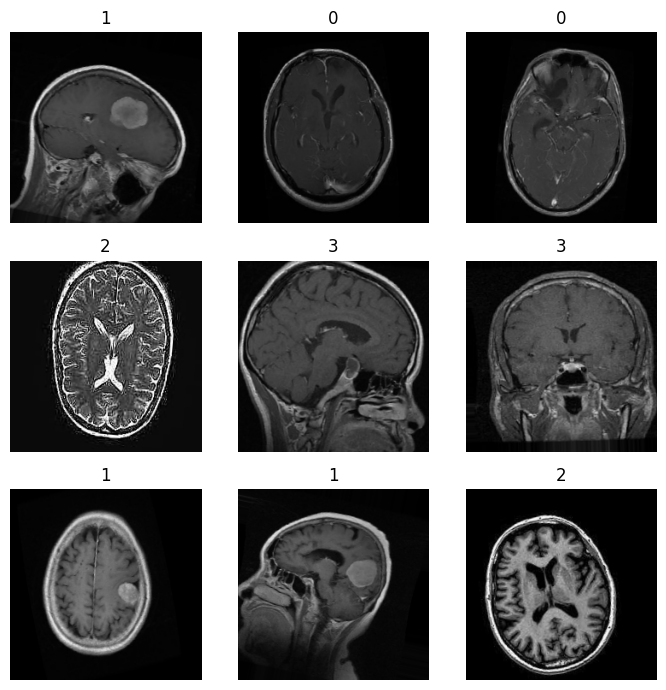

In [12]:
plt.figure(figsize=(7,7))
imgs, labels = next(train_gen)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(imgs[i])
    plt.title(np.argmax(labels[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()

# Build the model

In [29]:
NUM_CLASSES = train_gen.num_classes


# Constants
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = train_gen.num_classes 

# Search Space Definition
search_space = {
    "lr": [0.01, 0.001, 0.0001],
    "dense_units": [128, 256, 512],
    "dropout": [0.3, 0.4, 0.5]
}

# The build function you provided
def build_model(lr, dropout_rate, dense_units):
    K.clear_session()
    base = MobileNetV2(input_shape=(224,224,3), include_top=False, weights="imagenet")
    base.trainable = False

    inp = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = Lambda(lambda img: tf.image.resize(img, (224,224)))(inp)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [30]:
def fitness_function(indices):
    # Map continuous FPA values to nearest discrete index [0, 1, 2]
    idx_lr = int(np.clip(round(indices[0]), 0, 2))
    idx_units = int(np.clip(round(indices[1]), 0, 2))
    idx_drop = int(np.clip(round(indices[2]), 0, 2))
    
    current_lr = search_space["lr"][idx_lr]
    current_units = search_space["dense_units"][idx_units]
    current_drop = search_space["dropout"][idx_drop]
    
    print(f"\nTesting: LR={current_lr}, Units={current_units}, Dropout={current_drop}")
    
    model = build_model(current_lr, current_drop, current_units)
    
    # Train for 3 epochs as requested
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=3, 
        verbose=1
    )
    
    # We want to maximize accuracy, so fitness is the best val_accuracy
    accuracy = max(history.history['val_accuracy'])
    
    # Clean up to prevent GPU memory leaks
    del model
    gc.collect()
    K.clear_session()
    
    return accuracy

In [31]:
class FlowerPollinationAlgorithm:
    def __init__(self, fitness_func, dim=3, n_flowers=5, p=0.8):
        self.fitness_func = fitness_func
        self.dim = dim
        self.n_flowers = n_flowers
        self.p = p  # Switch probability
        self.lb = 0
        self.ub = 2
        
        # Initialize flowers (population)
        self.flowers = np.random.uniform(self.lb, self.ub, (n_flowers, dim))
        self.fitness = np.array([self.fitness_func(f) for f in self.flowers])
        
        self.best_idx = np.argmax(self.fitness)
        self.best_flower = self.flowers[self.best_idx].copy()
        self.best_fitness = self.fitness[self.best_idx]

    def levy_flight(self, Lambda=1.5):
        sigma = (math.gamma(1 + Lambda) * math.sin(math.pi * Lambda / 2) / 
                (math.gamma((1 + Lambda) / 2) * Lambda * 2**((Lambda - 1) / 2)))**(1 / Lambda)
        u = np.random.normal(0, sigma, self.dim)
        v = np.random.normal(0, 1, self.dim)
        return 0.01 * u / (np.abs(v)**(1 / Lambda))

    def run(self, max_iter=7):
        for t in range(max_iter):
            print(f"\n--- FPA Iteration {t+1}/{max_iter} ---")
            for i in range(self.n_flowers):
                if random.random() < self.p:
                    # Global Pollination (Levy Flight)
                    L = self.levy_flight()
                    new_flower = self.flowers[i] + L * (self.best_flower - self.flowers[i])
                else:
                    # Local Pollination
                    j, k = random.sample(range(self.n_flowers), 2)
                    epsilon = random.random()
                    new_flower = self.flowers[i] + epsilon * (self.flowers[j] - self.flowers[k])
                
                # Boundary check
                new_flower = np.clip(new_flower, self.lb, self.ub)
                new_fitness = self.fitness_func(new_flower)
                
                if new_fitness > self.fitness[i]:
                    self.flowers[i] = new_flower
                    self.fitness[i] = new_fitness
            
            # Update global best
            if np.max(self.fitness) > self.best_fitness:
                self.best_idx = np.argmax(self.fitness)
                self.best_flower = self.flowers[self.best_idx].copy()
                self.best_fitness = self.fitness[self.best_idx]
            
            print(f"Iteration {t+1} Best Accuracy: {self.best_fitness:.4f}")
            
        return self.best_flower, self.best_fitness

In [33]:
# Initialize and Run Optimizer
fpa = FlowerPollinationAlgorithm(fitness_function, n_flowers=5) 
best_params, best_score = fpa.run(max_iter=7)

# Final Results Mapping
final_lr = search_space["lr"][int(round(best_params[0]))]
final_units = search_space["dense_units"][int(round(best_params[1]))]
final_drop = search_space["dropout"][int(round(best_params[2]))]

print("\n" + "="*30)
print(f"OPTIMIZATION COMPLETE")
print(f"Best Val Accuracy: {best_score:.4f}")
print(f"Optimal Learning Rate: {final_lr}")
print(f"Optimal Dense Units: {final_units}")
print(f"Optimal Dropout: {final_drop}")
print("="*30)


Testing: LR=0.001, Units=128, Dropout=0.4
Epoch 1/3
 94/143 ━━━━━━━━━━━━━━━━━━━━ 24s 503ms/step - accuracy: 0.2927 - loss: 1.5647

2025-12-20 16:35:39.193680: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-20 16:35:39.329864: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.3058 - loss: 1.5066

2025-12-20 16:36:37.051084: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-20 16:36:37.187509: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


143/143 ━━━━━━━━━━━━━━━━━━━━ 125s 812ms/step - accuracy: 0.3061 - loss: 1.5057 - val_accuracy: 0.3839 - val_loss: 1.3081
Epoch 2/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 67s 470ms/step - accuracy: 0.3719 - loss: 1.2360 - val_accuracy: 0.3611 - val_loss: 1.2959
Epoch 3/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 464ms/step - accuracy: 0.4053 - loss: 1.1981 - val_accuracy: 0.3602 - val_loss: 1.2457

Testing: LR=0.01, Units=128, Dropout=0.4
Epoch 1/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 540ms/step - accuracy: 0.2981 - loss: 2.3764 - val_accuracy: 0.3471 - val_loss: 1.3188
Epoch 2/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 460ms/step - accuracy: 0.3357 - loss: 1.2893 - val_accuracy: 0.3436 - val_loss: 1.3146
Epoch 3/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 461ms/step - accuracy: 0.3592 - loss: 1.2517 - val_accuracy: 0.3953 - val_loss: 1.2387

Testing: LR=0.01, Units=512, Dropout=0.5
Epoch 1/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 535ms/step - accuracy: 0.3154 - loss: 3.1673 - val_accuracy: 0.3287 - val_loss: 1.3069
Epoch 2/3
143/1